In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os

os.chdir('../../experiments')

In [5]:
directory = "../data"

#### Transformer Functions

In [18]:
CLASS_COLORS = {
    0: (255, 0, 0),    # Red - T-shirt/top
    1: (0, 255, 0),    # Green - Trouser
    2: (0, 0, 255),    # Blue - Pullover
    3: (255, 255, 0),  # Yellow - Dress
    4: (255, 165, 0),  # Orange - Coat
    5: (128, 0, 128),  # Purple - Sandal
    6: (0, 255, 255),  # Cyan - Shirt
    7: (255, 105, 180),# Pink - Sneaker
    8: (128, 128, 128),# Gray - Bag
    9: (255, 255, 255) # White - Ankle boot
}

# Normalize color values to [0,1]
CLASS_COLORS = {k: np.array(v) / 255.0 for k, v in CLASS_COLORS.items()}

In [19]:
class ClassColorizeTransform:
    def __init__(self, class_colors):
        self.class_colors = class_colors

    def __call__(self, img, label):
        img = np.array(img) / 255.0  # Normalize grayscale to [0,1]
        img = np.expand_dims(img, axis=-1)  # Shape: (28,28,1)

        # Get the class-specific color
        color = self.class_colors[label]

        # Apply the class-specific color to all pixels
        colorized_img = img * color  # Element-wise multiplication

        return torch.tensor(colorized_img, dtype=torch.float32).permute(2, 0, 1)  # Convert to PyTorch tensor (C, H, W), keeping 3 channels


In [20]:
# Wrapper function to apply transform
class CustomFashionMNIST(torchvision.datasets.FashionMNIST):
    def __init__(self, *args, transform=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.custom_transform = transform

    def __getitem__(self, index):
        img, label = super().__getitem__(index)  # Get image and label
        if self.custom_transform:
            img = self.custom_transform(img, label)  # Apply color transform
        return img, label

#### Train Dataset

In [21]:
# Load the dataset with the custom transformation
train_dataset = CustomFashionMNIST(
    root=directory, train=True, download=True, transform=ClassColorizeTransform(CLASS_COLORS)
)

# DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


#### Visualization

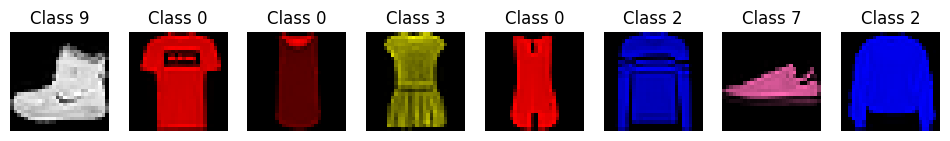

In [22]:
def show_images(dataset, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy image
        axes[i].imshow(image)
        axes[i].set_title(f"Class {label}")
        axes[i].axis("off")
    plt.show()

# Show sample colorized images
show_images(train_dataset)

#### Training

In [23]:
from train import train, test
from cnn import _2LayerCNN

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
models = [_2LayerCNN().to(device).to(torch.float32) for _ in range(2)]
optimizers = [optim.Adam(model.parameters()) for model in models]

In [ ]:
for model, optimizer in zip(models, optimizers):
    for epoch in range(1, 5):
        train(model, device, train_loader, optimizer, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298153


KeyboardInterrupt: 

#### Test Dataset 

In [35]:
def generate_random_color_set(length):
   
    # Generate random integers in the range [0, 255] for each color channel
    color_set = np.random.randint(0, 256, size=(length, 3))
    return color_set / 255.0 # Normalize to [0, 1]


In [38]:
def colorize_transform(img, color_set):
    # Convert tensor to numpy and remove channel dimension added by ToTensor()
    img = np.array(img).squeeze(0)  # Now shape (28, 28)
    
    # Normalize and expand to (28, 28, 1)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # Shape: (28, 28, 1)
    
    # Map to colors
    num_colors = len(color_set)
    color_indices = (img * (num_colors - 1)).astype(int)
    colorized_img = color_set[color_indices]  # Shape: (28, 28, 1, 3)
    
    # Remove the unnecessary singleton dimension
    colorized_img = colorized_img.squeeze(2)  # Shape: (28, 28, 3)
    
    # Convert to tensor and permute to (C, H, W)
    return torch.tensor(colorized_img, dtype=torch.float32).permute(2, 0, 1)

#### Random 9 colors

In [39]:
random_9_colors = generate_random_color_set(9)

In [40]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor first
    transforms.Lambda(lambda x: colorize_transform(x * 255, random_9_colors))  # Apply colorization
])

In [41]:
test_dataset = datasets.FashionMNIST(
    directory, train=False, transform=transform)

test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False)

In [52]:
for model in models:
    print("testing the next model")
    test(model, device, test_loader)

testing the next model


/tmp/ipykernel_91361/1492103977.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img).squeeze(0)  # Now shape (28, 28)


TypeError: 'dict_values' object is not subscriptable

#### 9 colors of Training

In [54]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor first
    transforms.Lambda(lambda x: colorize_transform(x * 255, np.array(list(CLASS_COLORS.values())) / 255.0 ))  # Apply colorization
])

In [55]:
test_dataset = datasets.FashionMNIST(
    directory, train=False, transform=transform)

test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False)

In [56]:
for model in models:
    print("testing the next model")
    test(model, device, test_loader)

testing the next model


/tmp/ipykernel_91361/1492103977.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img).squeeze(0)  # Now shape (28, 28)



Test set: Average loss: 0.0356, Accuracy: 1000/10000 (10.00%)

testing the next model


KeyboardInterrupt: 